In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None

In [2]:
Train = False # False if you do analysis with given simulations and estimates

In [3]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('source activate slim', 
                       '#time=0-1:00:00',
                       '#mem=1000M',
                       '#mem-per-cpu=None', 
                       '#job-name="sim"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=3')

### Parameters:

In [4]:
N = 50
Ne = 10000
L = 100000
r = 1.25e-8
mu = 2.5e-8

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne
h = 0.5

Args = {}

Args['Fn'] = {'Simulator':'slim', 'slimTxt':'Slim.txt', 
              'N':N, 'Ne':Ne, 'L':L, 'r':r, 'mu':mu, 
              's':0, 'h':0.5, 'extmut':0, 'reset_lost': 0,
              'Until':Ne, 'Freq':0.25, 'rep':0, 
              'srun':srun, 'srun_est':srun_est,
              'etapath':'etas/Fn.json', 'start': Until + 100,
              'name':'Neutral Model'}

for s in [0.02, 0.01, 0.003, 0.001]:
    for Freq in [0.25, 0.5, 0.75]:
        name = 's='+str(s)+'F='+str(Freq)
        arg = Args['Fn'].copy()
        arg['s'] = s
        arg['Freq'] = Freq
        arg['Until'] = 300000
        arg['name'] = name
        arg['reset_lost'] = 1
        Args[name] = arg

In [5]:
cID = 3 # simulation class id for directional selection constant pop size simulations
nrep = 250
X = Experiment(cID, nrep, Args)

## 1 Simulation

In [6]:
if Train:
    X.sim()

## 2 Population Size History estimation

In [7]:
X.calc_sfs()
X.train_eta()

Done!


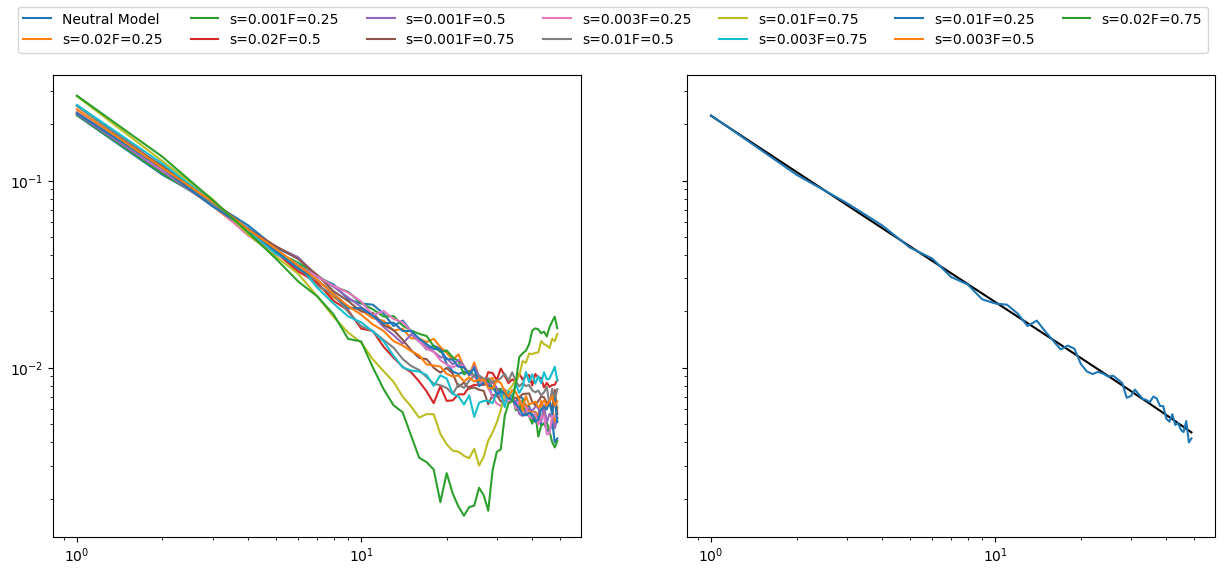

In [8]:
fig, ax = plt.subplots(1,2,figsize = (15,6), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)

for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend(ncol = 7, loc = 'upper center')

## 3 Optimizing $\beta$-imbalance and calculating summary stats

In [9]:
BIM = '/home/enes/bim/BIM.py'

if Train:
    for setid in X.setids:
        X.est(BIM, setid, now = 30, srun = srun_est, arg = '--r2t=0.005 --r2s=0.001')

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [11]:
if Train:
    for setid in X.setids:
        X.merge_outs(setid)

## 4 Analysis

In [12]:
stats = ['bsfs', 'TajD', 'ibtree', 'iColless']

### ROC Curves

In [13]:
myorder = [2, 3, 0, 1]

In [14]:
for s in [0.02, 0.01, 0.003, 0.001]:
    for F in [0.25,0.5,0.75]:
        k = 's='+str(s)+'F='+str(F)
        df = pd.read_csv(X.df[k])
        
        print(s,F)
        print(df[['btree', 'ibtree']].corr().iloc[0,1])
        

0.02 0.25
0.8375549667352421
0.02 0.5
0.7275957942062953
0.02 0.75
0.6546068922546717
0.01 0.25
0.8060653316421824
0.01 0.5
0.7444624659924057
0.01 0.75
0.6907749216254089
0.003 0.25
0.7866596210119756
0.003 0.5
0.7975720165614059
0.003 0.75
0.7811904740817553
0.001 0.25
0.8056952043343438
0.001 0.5
0.8377935255233664
0.001 0.75
0.8405150713779106


In [19]:
stats

['bsfs', 'TajD', 'ibtree', 'iColless']

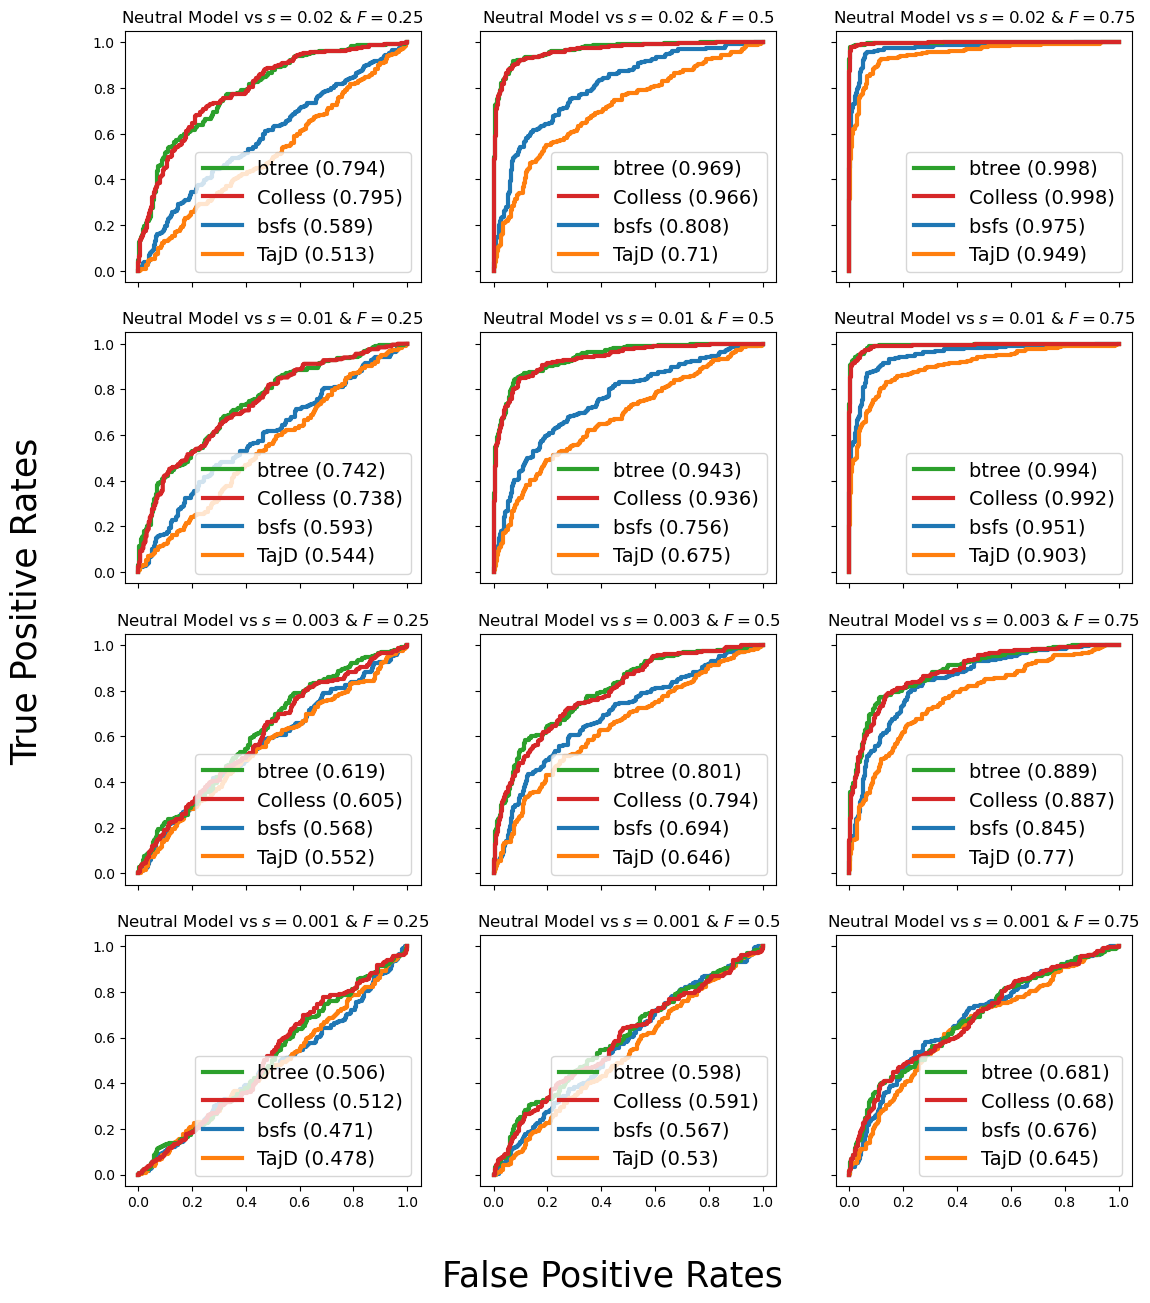

In [21]:
fig, ax = plt.subplots(4,3,figsize = (13,15), sharex = True, sharey = True)

aucs = {stat:[] for stat in stats}
for j, s in enumerate([0.02, 0.01, 0.003, 0.001]):
    
    
    Vs = [['Fn', 's='+str(s)+'F='+str(F)] for F in [0.25,0.5,0.75]]
    names = [['Neutral Model', '$s='+str(s)+'$ & $F='+str(F)+'$'] for F in [0.25,0.5,0.75]]
    
    for i, vs in zip(range(len(Vs)), Vs):
        for key in stats:
            k1, k2 = vs
            df1 = pd.read_csv(X.df[k1])
            df2 = pd.read_csv(X.df[k2])
            for pos in ['iColless', 'FulD']:
                df1[pos] = -df1[pos]
                df2[pos] = -df2[pos]
            
            if key == 'ibtree':
                label = 'btree'
            elif key == 'iColless':
                label = 'Colless'
            else:
                label = key
            
            auc = ROC(ax[j, i], df1[key], df2[key], score_ascending = False, label = label)
            
            aucs[key].append(auc)

        handles, labels = ax[j,i].get_legend_handles_labels()
        ax[j, i].legend([handles[_] for _ in myorder], [labels[_] for _ in myorder], loc = 'lower right',
                       prop={'size': 14})

            
    for i, vs in zip(range(len(Vs)), Vs):
        k1, k2 = vs
        ax[j, i].set_title(names[i][0]+' vs '+names[i][1])
        
fig.text(0.5, 0.05, 'False Positive Rates', ha='center', va='center', size = 25)
fig.text(0.05, 0.5, 'True Positive Rates', rotation = 90, ha='center', va='center', size = 25)
#plt.tight_layout()
plt.savefig('plots/Constant_Directional.jpg', dpi = 300)

In [24]:
from scipy.stats import wilcoxon
aucs = pd.DataFrame(aucs)

In [25]:
wilcoxon(aucs['bsfs'], aucs['TajD'], alternative = 'greater')[1], (aucs['bsfs']-aucs['TajD']).mean()

(0.0014367069639262613, 0.04826400000000001)

In [28]:
wilcoxon(aucs['ibtree'], aucs['iColless'], alternative = 'greater')[1], (aucs['ibtree']-aucs['iColless']).mean()

(0.0140280620746218, 0.0033673333333333424)

### Box plots

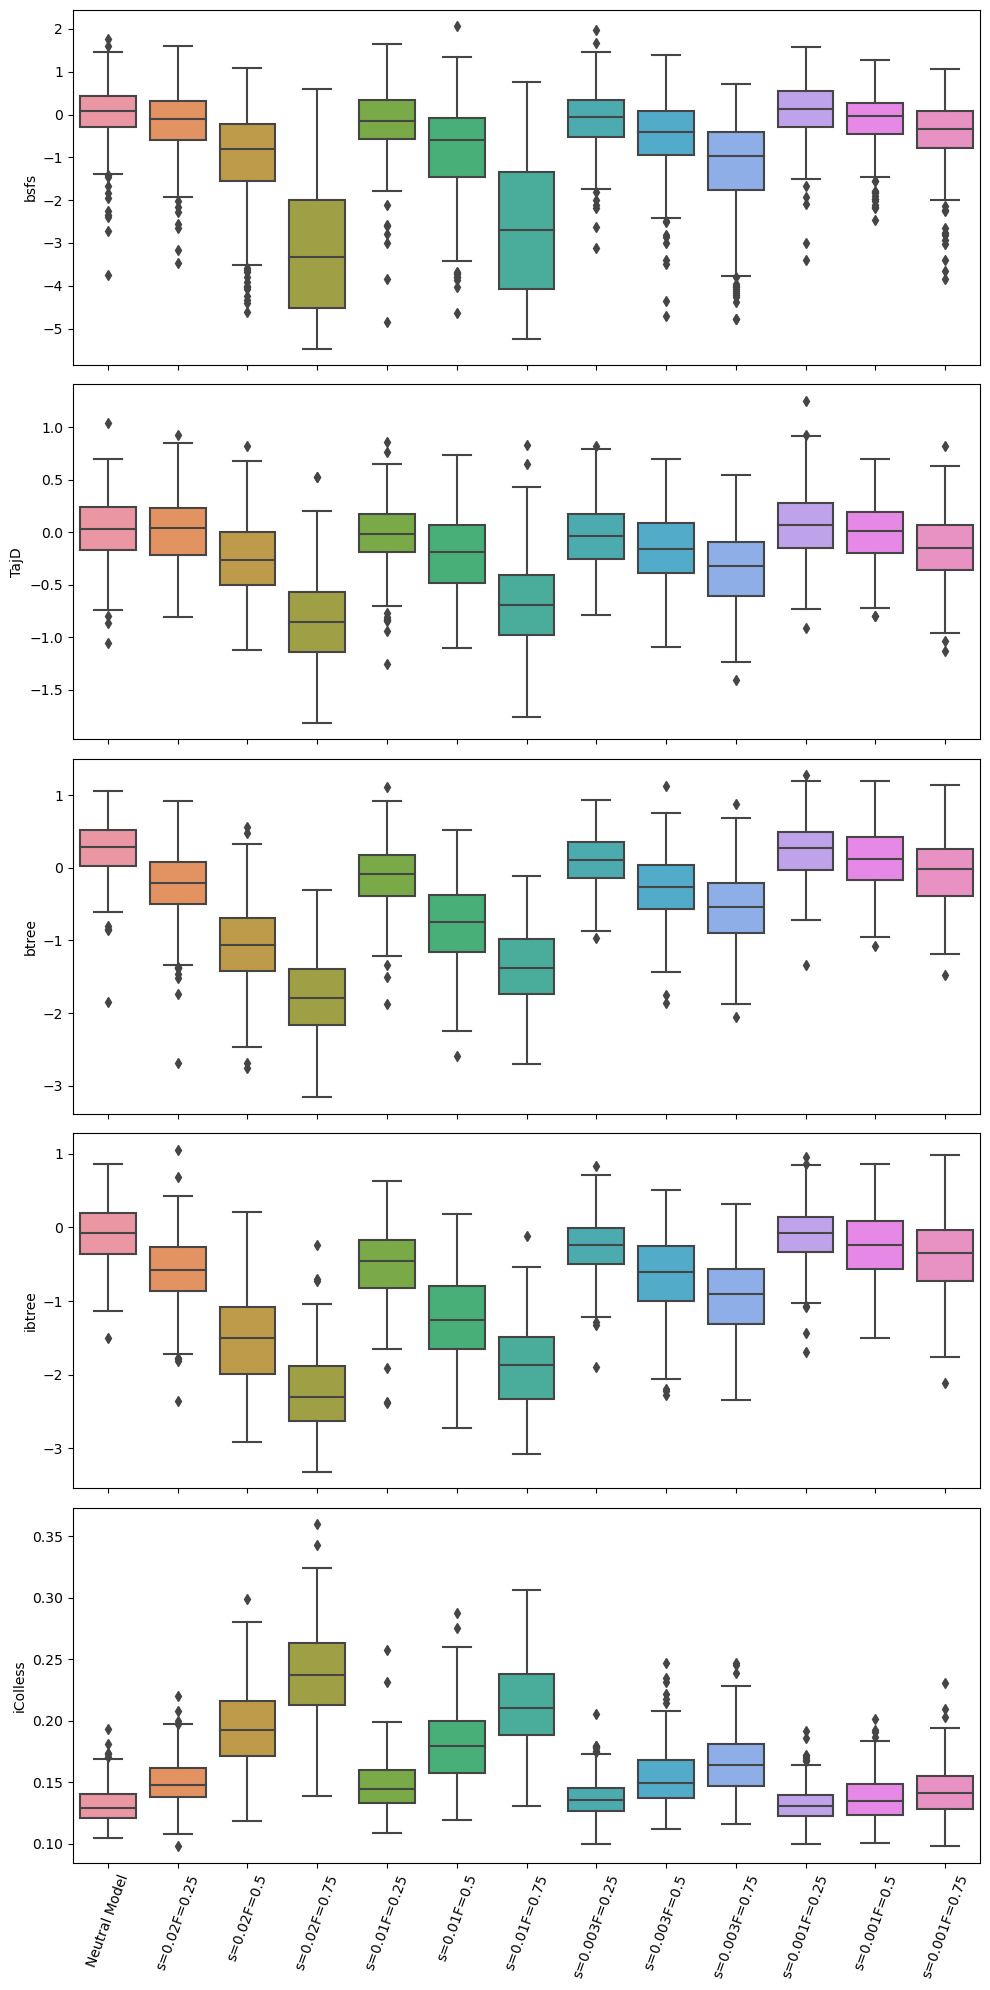

In [18]:
dfs = []
for setid in X.setids:
    df = pd.read_csv(X.df[setid])[['path']+stats]
    df['setid'] = Args[setid]['name']
    dfs.append(df)


fig, ax = plt.subplots(len(stats),figsize = (10,20), sharex = True)   
plt.xticks(rotation = 70)
dfs = pd.concat(dfs)
for i, stat in enumerate(stats):
    sns.boxplot(data=dfs, x='setid', y=stat, ax=ax[i])
    
    ax[i].set_xlabel(None)
plt.tight_layout()
plt.savefig('plots/Constant_Directional_box.jpg', dpi = 300)